In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom
from matplotlib_scalebar.scalebar import ScaleBar

In [52]:
dr = '/docker/mnt/d/research/D3/data/Cama_FLOOD'
elv_path = dr + '/glb_01min/elevtn.bin'
bsn_path = dr + '/glb_01min/basin.bin'

north = 65*60
south = 85*60
west = (180+90)*60
east = (180+110)*60
lat_res = 180*60
lon_res = 360*60

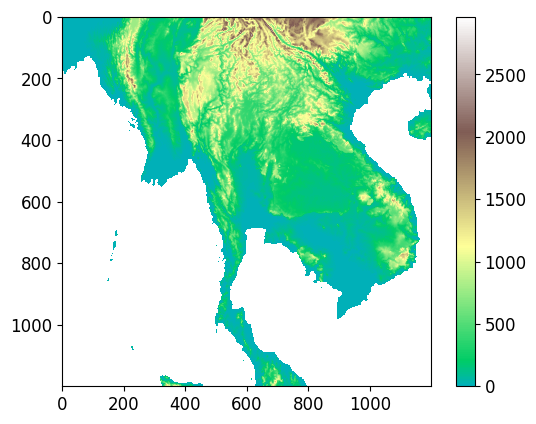

In [57]:
elv = np.fromfile(elv_path, 'f').reshape(lat_res, lon_res)
elv = np.ma.masked_where(elv<-8000, elv)
elv_thai = elv[north:south, west:east]

cmap_terrain = plt.cm.get_cmap('terrain')
cmap_colors = cmap_terrain(np.linspace(0.0, 1.0, 256))
cmap_colors = cmap_colors[50:]
cmap_elv = ListedColormap(cmap_colors)
plt.imshow(elv_thai, cmap=cmap_elv)
plt.colorbar()

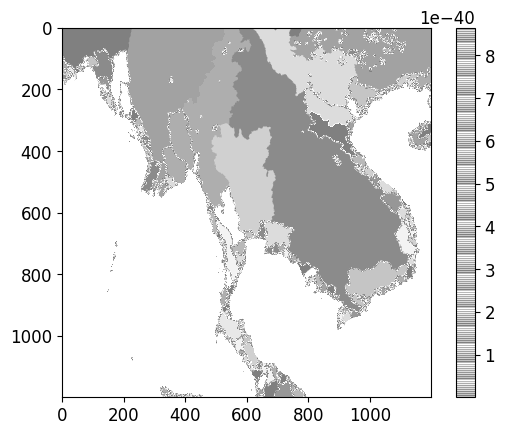

In [54]:
bsn = np.fromfile(bsn_path, 'f').reshape(lat_res,lon_res)
bsn_thai = bsn[north:south, west:east]

cmap_set3 = plt.cm.get_cmap('gray')
colors = cmap_set3(np.linspace(0, 1, 12))
rgba_values = []
for _ in range(5000):
    for i in colors:
        rgba_values.append(i)
cmap_bsn = ListedColormap(rgba_values)

plt.imshow(bsn_thai, cmap=cmap_bsn, alpha=0.5)
plt.colorbar()

In [55]:
def map_plot(img, cmap, alpha=0.8):
    fontsize = 12
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['font.family'] = 'sans-serif'
    
    xmin, xmax = 90, 110 
    ymin, ymax = 5, 25
    dx = 5
    projection = ccrs.PlateCarree(central_longitude=0)
    img_extent = (xmin, xmax, ymin, ymax) # location = (N5-25, E90-110)
    scale = '10m'
    countries = cfeature.NaturalEarthFeature('cultural',
                                             'admin_0_countries',
                                             scale,
                                             edgecolor='gray',
                                             facecolor='none')
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.set_extent([xmin, xmax, ymin, ymax], projection)
    
    mat = ax.matshow(img, extent=img_extent, transform=projection, cmap=cmap, alpha=alpha)
    ax.add_feature(countries)
    
    # ticks
    ax.tick_params(axis='both', which='both',
                   bottom=True, top=True, left=True, right=True,
                   labelbottom=True, labeltop=True, labelleft=True, labelright=True)
    xlabel = [f"E{i}°" for i in range(xmin, xmax+dx, dx)]
    ylabel = [f"N{i}°" for i in range(ymin, ymax+dx, dx)]
    ax.set_xticks(list(range(xmin, xmax+dx, dx)), crs=projection)
    ax.set_yticks(list(range(ymin, ymax+dx, dx)), crs=projection)
    ax.set_xticklabels(xlabel)
    ax.set_yticklabels(ylabel)
    
    
    # scale bar
    pixel = int(110)
    scalebar = ScaleBar(pixel, units='km', location='lower left')
    ax.add_artist(scalebar)
    
    # north arrow
    start_x = 1 + xmin
    start_y = 2 + ymin
    end_x = 1 + xmin
    end_y = 3 + ymin
    
    ax.arrow(start_x, start_y, end_x - start_x, end_y - start_y,
              width=0.02,  # 矢印の幅
              head_width=0.3,  # 矢印の先端の幅
              head_length=0.5,  # 矢印の先端の長さ
              fc='black',  # 矢印の塗りつぶし色
              ec='black'  # 矢印の枠線色
              )
    ax.text(end_x, end_y+0.5, 'N', ha='center', va='bottom')

    # colorbar
    cax = fig.add_axes([0.69, 0.17, 0.06, 0.08]) #[left, bottom, width, hieight]
    cbar = fig.colorbar(mat, cax=cax)
    cbar.set_ticks([])
    cbar.ax.set_xlabel('elevation')

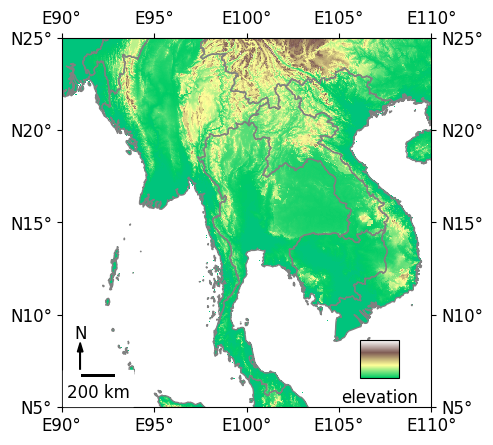

In [56]:
map_plot(elv_thai, cmap_elv, alpha=1)

In [ ]:
map_plot(bsn_thai, cmap_bsn, alpha=.5)

In [28]:
def double_plot(img1, cmap1, img2, cmap2, alpha1=0.9, alpha2=0.3):
    fontsize = 12
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['font.family'] = 'sans-serif'
    
    xmin, xmax, dx = 90, 110, 5 
    ymin, ymax, dx = 5, 25, 5
    projection = ccrs.PlateCarree(central_longitude=0)
    img_extent = (xmin, xmax, ymin, ymax) # location = (N5-25, E90-110)
    scale = '10m'
    countries = cfeature.NaturalEarthFeature('cultural',
                                             'admin_0_countries',
                                             scale,
                                             edgecolor='gray',
                                             facecolor='none')
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    
    mat = ax.matshow(img1, extent=img_extent, transform=projection, cmap=cmap1, alpha=alpha1)
    mat2 = ax.matshow(img2, extent=img_extent, transform=projection, cmap=cmap2, alpha=alpha2)
    
    ax.set_extent([xmin, xmax, ymin, ymax], projection)
    ax.set_xticks(list(range(xmin, xmax+dx, dx)), crs=projection)
    ax.set_yticks(list(range(ymin, ymax+dx, dx)), crs=projection)
    ax.add_feature(countries)
    
    fig.colorbar(mat, ax=ax)

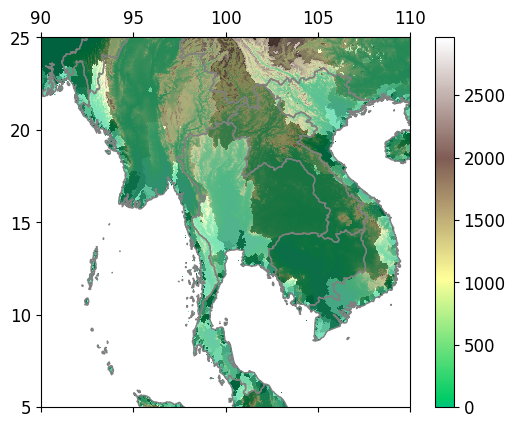

In [34]:
double_plot(elv_thai, cmap_elv, bsn_thai, cmap_bsn, alpha1=1.0, alpha2=0.5)

In [35]:
def create_basin_baundary_line(map_data):
    grid_size = 1

    # グリッドに分割した地図データを作成
    grid_data = map_data[::grid_size, ::grid_size]

    # 隣接するグリッドセル間で値が異なる箇所を境界として特定
    boundaries = np.zeros_like(grid_data)
    boundaries[1:, :] = grid_data[1:, :] != grid_data[:-1, :]
    boundaries[:, 1:] |= grid_data[:, 1:] != grid_data[:, :-1]

    # 境界線を元の解像度に拡大
    expanded_boundaries = np.repeat(np.repeat(boundaries, grid_size, axis=1), grid_size, axis=0)

    # 境界線を描写などの処理を行うことができます
    print(expanded_boundaries)
    plt.imshow(expanded_boundaries, cmap='gray_r', alpha=0.6)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


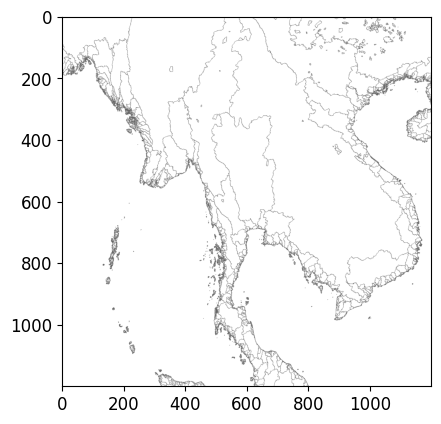

In [36]:
bsn_multi = bsn_thai*1e50
bsn_int = bsn_multi.astype(int)
create_basin_baundary_line(bsn_int)

In [44]:
def highlight(elv):
    lat_res = 180*60
    lon_res = 360*60

    elv_face = np.ma.zeros_like(elv)

    for lat in range(lat_res):
        for lon in range(lon_res):
            if not np.ma.is_masked(elv_face[lat, lon]):
                if north <= lat <= south and west <= lon <= east:
                    elv_face[lat, lon] = 1
                else:
                    elv_face[lat, lon] = 0
                    
    return elv_face

In [45]:
elv_highlight = highlight(elv)

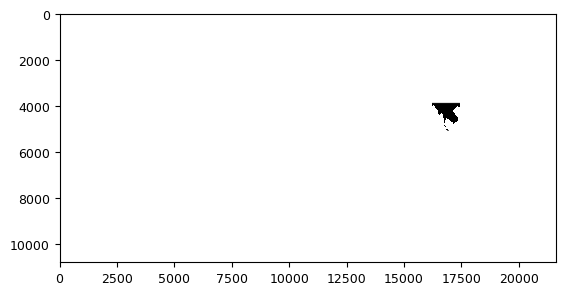

In [46]:
plt.imshow(elv_highlight, cmap='gray_r')

In [39]:
def worldmap_highlighted(highlight):
    fontsize = 9
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['font.family'] = 'sans-serif'
    
    xmin, xmax, dx = -180, 180, 30
    ymin, ymax, dx = -90, 90, 30
    projection = ccrs.PlateCarree(central_longitude=0)
    img_extent = (xmin, xmax, ymin, ymax) # location = (N5-25, E90-110)
    scale = '10m'
    land_feature = cfeature.LAND
    
    # 領域を四角で囲むパスを作成
    min_lon = 90.0  # 最小経度
    max_lon = 110.0  # 最大経度
    min_lat = 5.0   # 最小緯度
    max_lat = 25.0   # 最大緯度
    vertices = [(min_lon, min_lat),
                (max_lon, min_lat),
                (max_lon, max_lat),
                (min_lon, max_lat)]
    boundary = sgeom.box(min_lon, min_lat, max_lon, max_lat)
    boundary = cfeature.ShapelyFeature([boundary], 
                                       projection, 
                                       edgecolor='red', 
                                       facecolor='none')

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    
    mat = ax.matshow(highlight, 
                     extent=img_extent, 
                     transform=projection, 
                     cmap='gray_r', 
                     alpha=0.5)
    
    ax.set_extent([xmin, xmax, ymin, ymax], projection)
    ax.set_xticks(list(range(xmin, xmax+dx, dx)), crs=projection)
    ax.set_yticks(list(range(ymin, ymax+dx, dx)), crs=projection)
    ax.add_feature(land_feature, facecolor='lightgray')
    ax.add_feature(boundary, linewidth=1)

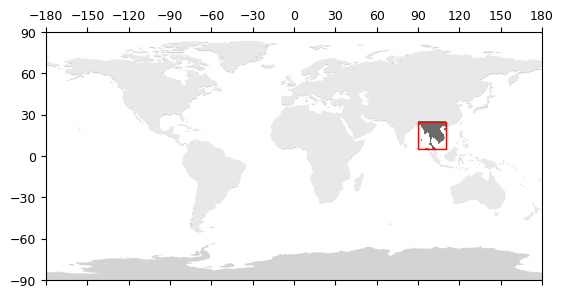

In [47]:
worldmap_highlighted(elv_highlight)